In [1]:
import numpy as np
from numpy import ndarray
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### Задание 1. Реализуйте нейронную сеть с двумя сверточными слоями, и одним полносвязным с нейронами с кусочно-линейной функцией активации. Какова точность построенное модели?

In [2]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset: ndarray = save['train_dataset']
    train_labels: ndarray = save['train_labels']
    valid_dataset: ndarray = save['valid_dataset']
    valid_labels: ndarray = save['valid_labels']
    test_dataset: ndarray = save['test_dataset']
    test_labels: ndarray = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10
num_channels = 1  # grayscale
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64


In [4]:
def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])


In [6]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [7]:
graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    # // equals math.floor
    layer3_weights = tf.Variable(
        tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases


    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
num_steps = 5001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if step % 50 == 0:
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))

    print('Original Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    first_preds = test_prediction.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Minibatch loss at step 0: 2.974770
Minibatch accuracy: 0.0%
Validation accuracy: 11.0%
Minibatch loss at step 50: 1.675316
Minibatch accuracy: 43.8%
Validation accuracy: 64.4%
Minibatch loss at step 100: 0.616832
Minibatch accuracy: 81.2%
Validation accuracy: 75.1%
Minibatch loss at step 150: 0.913940
Minibatch accuracy: 75.0%
Validation accuracy: 75.2%
Minibatch loss at step 200: 0.410027
Minibatch accuracy: 93.8%
Validation accuracy: 77.7%
Minibatch loss at step 250: 0.841983
Minibatch accuracy: 75.0%
Validation accuracy: 79.2%
Minibatch loss at step 300: 1.280766
Minibatch accuracy: 62.5%
Validation accuracy: 78.6%
Minibatch loss at step 350: 1.210228
Minibatch accuracy: 68.8%
Validation accuracy: 79.6%
Minibatch loss at step 400: 0.984858
Minibatch accuracy: 75.0%
Validation accuracy: 81.2%
Minibatch loss at step 450: 0.441086
Minibatch accuracy: 87.5%
Validation accuracy: 81.1%
Minibatch loss at step 500: 0.

#### Задание 2. Замените один из сверточных слоев на слой, реализующий операцию пулинга (Pooling) с функцией максимума или среднего. Как это повлияло на точность классификатора?

In [9]:
graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

    layer3_weights = tf.Variable(
        tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


    # Model.
    def model(data):
        conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        conv2 = tf.nn.relu(tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases)
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
        fc1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(fc1, layer4_weights) + layer4_biases


    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [10]:
num_steps = 5001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if step % 50 == 0:
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))

    print('Max pool Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    second_preds = test_prediction.eval()

Minibatch loss at step 0: 5.093078
Minibatch accuracy: 6.2%
Validation accuracy: 14.2%
Minibatch loss at step 50: 2.180482
Minibatch accuracy: 12.5%
Validation accuracy: 33.7%
Minibatch loss at step 100: 1.096039
Minibatch accuracy: 56.2%
Validation accuracy: 57.0%
Minibatch loss at step 150: 0.709919
Minibatch accuracy: 68.8%
Validation accuracy: 64.6%
Minibatch loss at step 200: 0.506075
Minibatch accuracy: 93.8%
Validation accuracy: 75.1%
Minibatch loss at step 250: 0.878394
Minibatch accuracy: 81.2%
Validation accuracy: 77.7%
Minibatch loss at step 300: 1.037832
Minibatch accuracy: 68.8%
Validation accuracy: 76.7%
Minibatch loss at step 350: 1.000137
Minibatch accuracy: 75.0%
Validation accuracy: 79.5%
Minibatch loss at step 400: 0.877154
Minibatch accuracy: 75.0%
Validation accuracy: 81.3%
Minibatch loss at step 450: 0.459679
Minibatch accuracy: 87.5%
Validation accuracy: 81.2%
Minibatch loss at step 500: 0.756392
Minibatch accuracy: 81.2%
Validation accuracy: 81.7%
Minibatch loss

#### Задание 3. Реализуйте классическую архитектуру сверточных сетей LeNet-5 (http://yann.lecun.com/exdb/lenet/).

In [11]:
graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)  # count the number of steps taken.

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

    layer3_weights = tf.Variable(
        tf.truncated_normal([image_size // 4 * image_size // 4 * depth, 120], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[120]))

    layer4_weights = tf.Variable(tf.truncated_normal([120, 84], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[84]))

    layer5_weights = tf.Variable(tf.truncated_normal([84, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


    # Model.
    def model(data, keep_prob):
        conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        conv2 = tf.nn.relu(tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases)
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])

        fc1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        fc2 = tf.nn.relu(tf.matmul(fc1, layer4_weights) + layer4_biases)

        y_conv = tf.nn.softmax(tf.matmul(fc2, layer5_weights) + layer5_biases)

        return y_conv


    # Training computation.
    y_conv = model(tf_train_dataset, 0.5)
    y_ = tf_train_labels
    loss = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(1e-1, global_step, num_steps, 0.7, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = y_conv
    valid_prediction = model(tf_valid_dataset, 1.0)
    test_prediction = model(tf_test_dataset, 1.0)

In [12]:
num_steps = 5001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if step % 300 == 0:
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))

    print('Lenet 5 Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    third_preds = test_prediction.eval()


Minibatch loss at step 0: 3.405826
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 300: 0.969236
Minibatch accuracy: 75.0%
Validation accuracy: 79.9%
Minibatch loss at step 600: 0.702899
Minibatch accuracy: 81.2%
Validation accuracy: 83.9%
Minibatch loss at step 900: 0.967502
Minibatch accuracy: 68.8%
Validation accuracy: 84.9%
Minibatch loss at step 1200: 0.224973
Minibatch accuracy: 93.8%
Validation accuracy: 85.6%
Minibatch loss at step 1500: 0.202479
Minibatch accuracy: 100.0%
Validation accuracy: 86.0%
Minibatch loss at step 1800: 0.829737
Minibatch accuracy: 62.5%
Validation accuracy: 83.9%
Minibatch loss at step 2100: 0.025870
Minibatch accuracy: 100.0%
Validation accuracy: 86.7%
Minibatch loss at step 2400: 0.155660
Minibatch accuracy: 100.0%
Validation accuracy: 87.4%
Minibatch loss at step 2700: 0.289813
Minibatch accuracy: 87.5%
Validation accuracy: 87.4%
Minibatch loss at step 3000: 0.471408
Minibatch accuracy: 87.5%
Validation accuracy: 87.4%
Mi

#### Задание 4. Сравните максимальные точности моделей, построенных в лабораторных работах 1-3.  Как можно объяснить полученные различия?

In [13]:
def plot_diffs(dataset, sample_size):
    fig: plt.Figure = plt.figure()

    sample_images = dataset[np.random.choice(dataset.shape[0], sample_size * sample_size)]
    sample_images = sample_images.reshape(sample_size, sample_size, *dataset.shape[-2:])

    for image_i in range(sample_size):
        for image_j in range(sample_size):
            sample_image = sample_images[image_i][image_j]
            ax = fig.add_subplot(sample_size, sample_size, image_i * sample_size + (image_j + 1))
            ax.imshow(sample_image)
            ax.set_axis_off()

    plt.show()


In [14]:
print(accuracy(first_preds, test_labels), np.unique(first_preds), first_preds.shape)
print(accuracy(second_preds, test_labels), np.unique(second_preds), second_preds.shape)
print(accuracy(third_preds, test_labels), np.unique(third_preds), third_preds.shape)

first_false_indices = np.argwhere(np.argmax(first_preds, axis=1) != np.argmax(test_labels, axis=1)).flatten()
first_true_indices = np.argwhere(np.argmax(first_preds, axis=1) == np.argmax(test_labels, axis=1)).flatten()
second_false_indices = np.argwhere(np.argmax(second_preds, axis=1) != np.argmax(test_labels, axis=1)).flatten()
second_true_indices = np.argwhere(np.argmax(first_preds, axis=1) == np.argmax(test_labels, axis=1)).flatten()
third_false_indices = np.argwhere(np.argmax(third_preds, axis=1) != np.argmax(test_labels, axis=1)).flatten()
third_true_indices = np.argwhere(np.argmax(first_preds, axis=1) == np.argmax(test_labels, axis=1)).flatten()

first_true_dataset = test_dataset[first_true_indices]
second_true_dataset = test_dataset[second_true_indices]
third_true_dataset = test_dataset[third_true_indices]

first_diff_dataset = test_dataset[np.setdiff1d(first_false_indices, second_false_indices)]
second_diff_dataset = test_dataset[np.setdiff1d(second_false_indices, third_false_indices)]

# Reshape
first_true_dataset = first_true_dataset.reshape(first_true_dataset.shape[:3])
second_true_dataset = second_true_dataset.reshape(second_true_dataset.shape[:3])
third_true_dataset = third_true_dataset.reshape(third_true_dataset.shape[:3])
first_diff_dataset = first_diff_dataset.reshape(first_diff_dataset.shape[:3])
second_diff_dataset = second_diff_dataset.reshape(second_diff_dataset.shape[:3])

92.6 [4.6020468e-10 5.3857829e-10 7.3517553e-10 ... 9.9997795e-01 9.9998140e-01
 9.9999523e-01] (10000, 10)
93.6 [1.1792422e-11 1.2988629e-11 1.5652042e-11 ... 9.9999690e-01 9.9999714e-01
 9.9999738e-01] (10000, 10)
94.14 [6.3674448e-11 7.4572577e-11 9.9377714e-11 ... 9.9999964e-01 9.9999976e-01
 9.9999988e-01] (10000, 10)


In [15]:
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    a = test_prediction.eval()

Первая сеть с двумя сверточными слоями и одним полносвязным показала точность 92.6. 
Вторая сеть - 93.6 Сеть LeNet - 5 - 94.1 
Различия можно объяснить тем, что при добавлении дополнительных слоев (pooling слоя в первом случае, полносвязного во втором)б
сеть может запоминать более сложные закономерности и учить более "сложные" символы. 

На этом рисунке можно увидеть какие буквы угадываются как правильные (они более простые)

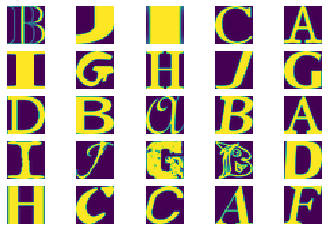

In [16]:
plot_diffs(third_true_dataset, 5)

А на этом рисунке можно увидеть символы, которые правильно были угаданы сетью LeNet, но неправильно второй сетью 
(имеют менее выраженные признаки символов).

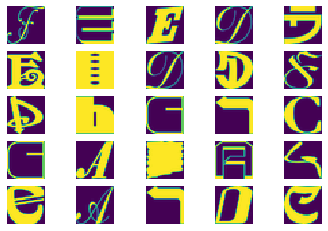

In [17]:
plot_diffs(second_diff_dataset, 5)

Из этого можно сделать вывод, что дополнительный полносвязный слой в сети LeNet-5 позволяет ей запоминать более сложные символы.